## Load The Data

In [10]:
import spacy
nlp = spacy.load('pl_core_news_sm')

In [13]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

df = pd.read_csv("colocates.csv", parse_dates= ['date'])
#df.colocate = df.colocate.apply(lambda colocate: " ".join([token.lemma_ for token in nlp(colocate)]) )
df.head()

,text_id,date,source,colocates,id
0,111,2021-02-21,DoRzeczy,twierdzą niezbędne żeby przeciwstawić się zmi...,0
1,156,2021-02-28,DoRzeczy,fałszywy alarm jak panika wokół zmiany klimatu...,1
2,156,2021-02-28,DoRzeczy,klimatyści tak jak model kosztów zmian klimaty...,2
3,156,2021-02-28,DoRzeczy,2030 r aby rozwiązać problem zmian klimatyczn...,3
4,156,2021-02-28,DoRzeczy,trzeba by zrobić żeby utrzymać zmiany klimatyc...,4


In [18]:
df['word'] = df.colocates.str.split(" ")
df = df.explode('word')
df.drop('colocates', inplace=True, axis=1)
df.head()

,text_id,date,source,id,word
0,111,2021-02-21,DoRzeczy,0,twierdzą
0,111,2021-02-21,DoRzeczy,0,
0,111,2021-02-21,DoRzeczy,0,niezbędne
0,111,2021-02-21,DoRzeczy,0,żeby
0,111,2021-02-21,DoRzeczy,0,przeciwstawić


In [19]:
window_width = 6 * 30 # 6 months
time_step = 3 * 30 # 3 months

start_date = df.date.min()
end_date = start_date + datetime.timedelta(days=window_width)
max_date = df.date.max()

df['window_group'] = None
index = 0
dates = []
while start_date < max_date:
    df.loc[df.date.between(start_date, end_date), 'window_group'] = index
    end_date += datetime.timedelta(days=time_step)
    start_date += datetime.timedelta(days=time_step)
    dates.append(start_date + datetime.timedelta(days=window_width/2))
    index += 1
    
print(f"{index + 1} windows created")

34 windows created


In [20]:
n_words =len(df['word'].unique())
print(f"Number of unique words: {n_words}")

Number of unique words: 15332


# Vector

Text(0, 0.5, 'Number of nodes')

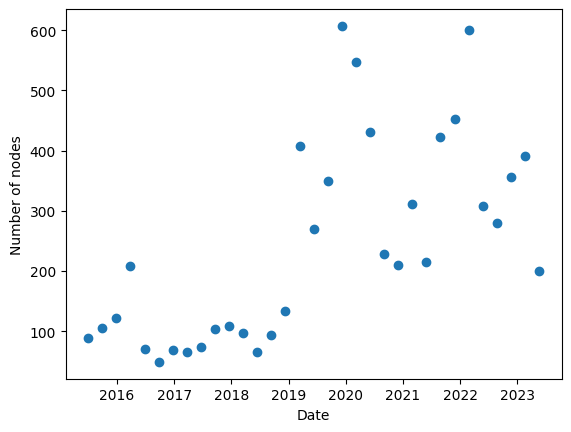

In [21]:
window_nodes_count = df.groupby('window_group').id.unique().apply(len)
plt.scatter(dates, window_nodes_count)
plt.xlabel('Date')
plt.ylabel('Number of nodes')

In [22]:
import seaborn as sns
count_words = df['word'].value_counts()
count_words.describe()

count     15332.000000
mean         89.047352
std        1289.197633
min           9.000000
25%          13.000000
50%          13.000000
75%          39.000000
max      113705.000000
Name: count, dtype: float64

Text(0, 0.5, 'Count')

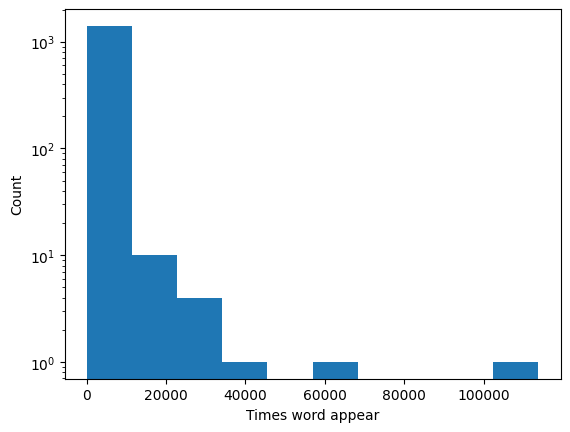

In [23]:
plt.hist(count_words[count_words > 100])
plt.yscale('log')
plt.xlabel('Times word appear')
plt.ylabel('Count')

# Colocates By Score

In [30]:
df['word'].value_counts().head(100)

word
            113705
klimatu      61566
zmian        43919
w            34061
zmiany       32435
             ...  
walka         1241
jako          1237
skutkami      1236
działań       1222
panelu        1220
Name: count, Length: 100, dtype: int64

In [25]:
import os
import pandas as pd

path = "corpus"
corp_files = os.listdir(path)
data_list = []
cols = ["text", "id", 'date', 'source']

for file in corp_files:
    # Load the data
    data = pd.read_csv(path+"/"+file, parse_dates=['date'])
   
    # Make sure to only include columns of interest
    if 'id' not in data.columns:
        print(f"No id in {file}")
        data['id'] = data.index
    data = data[cols]   

    # Append to list
    data_list.append(data)

df_corp = pd.concat(data_list)
df_corp = df_corp[df_corp['text'].isna() == False]

In [34]:
import numpy as np
def MI(colocate, df_corp, df, n, fa):
    fb = df_corp['text'].apply(lambda x: colocate in x).sum()  
    fab = df[df['word'] == colocate]['id'].nunique()
    return np.log2(n * (fab / (fa * fb)))

fa = df.id.nunique()
n = (df_corp['text'].str.split(" ").apply(lambda x: len(x)) - 1).sum()

In [36]:
MI('walka', df_corp, df, n, fa)

7.72523815114029

In [ ]:
#Todo: Delta P

# Selected Colocates into Vector

In [27]:
#Todo: decide what does it mean to colocate with the other word
#Frequency treshold with normalization 